# 2 site exact solutions

Created 02/12/2025

Objectives:
* Find exact solutions with boundary operators of width 2.

# Package imports

In [1]:
import sys
sys.path.append('../')

In [6]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [7]:
from itertools import chain, combinations
from collections import defaultdict
import re

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [9]:
from tqdm import tqdm

In [10]:
import quimb as qu
import quimb.tensor as qtn

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [11]:
DATA_DIR = r"../data/transverse_cluster_200_site_dmrg"

In [12]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [13]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [14]:
psi_dict = dict()

In [18]:
for b in b_parameters:
    mps_psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    psi_arrays = list()
    psi_arrays.append(mps_psi.get_B(0, 'Th')[0, ...].to_ndarray())
    for i in range(1, mps_psi.L-1):
        psi_arrays.append(mps_psi.get_B(i).to_ndarray())
    psi_arrays.append(mps_psi.get_B(mps_psi.L-1)[..., 0].to_ndarray())

    quimb_psi = (
        qtn
        .tensor_1d
        .MatrixProductState(psi_arrays, shape='lpr')
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = quimb_psi

# Definitons

In [20]:
MAX_VIRTUAL_BOND_DIM = 8
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [21]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [22]:
npc_I = to_npc_array(np_I)
npc_X = to_npc_array(np_X)
npc_Y = to_npc_array(np_Y)
npc_Z = to_npc_array(np_Z)

In [23]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [24]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    left_boundary_sites = list(range(
        leftmost_symmetry_site-num_boundary_sites,
        leftmost_symmetry_site
    ))

    right_boundary_sites = list(range(
        leftmost_symmetry_site+num_symmetry_sites,
        leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites
    ))
    
    indices_to_map = list(chain(left_boundary_sites, right_boundary_sites))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    """
    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )
    """

    tnc = tn.contract()

    fuse_maps = [
        ('k_left', (f'k{i}' for i in left_boundary_sites)),
        ('b_left', (f'b{i}' for i in left_boundary_sites)),
        ('k_right', (f'k{i}' for i in right_boundary_sites)),
        ('b_right', (f'b{i}' for i in right_boundary_sites))
    ]

    tnc.fuse(fuse_maps, inplace=True)

    return tnc

## Optimisation functions

In [34]:
def solve_for_boundary_operators(rdm, num_iters=20):
    scores = list()

    u_left = qtn.tensor_builder.rand_tensor(
        (4, 4),
        inds=['k_left', 'b_left'],
        dtype='complex64'
    )

    u_right = qtn.tensor_builder.rand_tensor(
        (4, 4),
        inds=['k_right', 'b_right'],
        dtype='complex64'
    )

    for _ in range(num_iters):
        right_rdm = (rdm & u_left).contract()
        data = right_rdm.data
        U, S, VH = np.linalg.svd(data)
        scores.append(np.sum(S))
    
        sol = (U @ VH).conj().T
        u_right = qtn.Tensor(sol, inds = ['b_right', 'k_right'])
        
        left_rdm = (rdm & u_right).contract()
        data = left_rdm.data
        U, S, VH = np.linalg.svd(data)
        scores.append(np.sum(S))
    
        sol = (U @ VH).conj().T
        u_left = qtn.Tensor(sol, inds = ['b_left', 'k_left'])

    return (u_left, u_right), scores

## SPT functions

In [19]:
def calculate_proj_rep_phase(state_g, left_schmidt_values_g, unitary_h,
                             state_gh,
                             left_environment,
                             max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    prod_state, _ = multiply_stacked_unitaries_against_mps(
        unitary_h,
        state_g,
        left_schmidt_values_g,
        max_virtual_bond_dim
    )

    exp = inner_product_b_tensors(prod_state, state_gh, left_environment)

    return exp/(np.abs(exp))

In [20]:
def get_proj_rep_phases(mps_tensors, left_schmidt_values, unitaries,
                        left_environment):
    mps_dict = {
        k: v for k, v in zip(symmetry_labels[1:], mps_tensors)
    }

    schmidt_vals_dict = {
        k: v for k, v in zip(symmetry_labels[1:], left_schmidt_values)
    }

    unitaries_dict = {
        k: v for k, v in zip(symmetry_labels[1:], unitaries)
    }

    out_phases = list()

    for a, b, c in group_products:
        phase = calculate_proj_rep_phase(
            mps_dict[a],
            schmidt_vals_dict[a],
            unitaries_dict[b],
            mps_dict[c],
            left_environment,
            max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
        )

        out_phases.append(phase)

    return out_phases

In [21]:
def get_right_proj_rep_phases_from_optimizers(optimizers):
    mps_tensors = [
        o.top_right_mps_tensors
        for o in optimizers[1:]
    ]

    left_schmidt_values = [
        o.current_right_side_left_schmidt_values
        for o in optimizers[1:]
    ]

    unitaries = [
        o.right_unitaries for o in optimizers[1:]
    ]

    left_environment = optimizers[0].right_side_left_symmetry_environment

    out = get_proj_rep_phases(
        mps_tensors,
        left_schmidt_values,
        unitaries,
        left_environment
    )

    return out

In [22]:
def get_left_proj_rep_phases_from_optimizers(optimizers):
    mps_tensors = [
        o.top_left_mps_tensors
        for o in optimizers[1:]
    ]

    left_schmidt_values = [
        o.current_left_side_right_schmidt_values
        for o in optimizers[1:]
    ]

    unitaries = [
        o.left_unitaries for o in optimizers[1:]
    ]

    left_environment = optimizers[0].left_side_right_symmetry_environment

    out = get_proj_rep_phases(
        mps_tensors,
        left_schmidt_values,
        unitaries,
        left_environment
    )

    return out

## SPT extraction functions

In [39]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [40]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [41]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [42]:
e, a, b, c = symmetry_labels

In [43]:
group_products = [
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

In [44]:
def relabel_mpo(mpo, k_label, b_label):
    site_locs = [
        int(k[1:]) for k in mpo.tag_map
        if bool(re.search(regex_p, k))
    ]

    k_in_indices = [f'k{i}' for i in site_locs]
    j_in_indices = [f'b{i}' for i in site_locs]

    k_out_indices = [f'{k_label}{i}' for i in site_locs]
    j_out_indices = [f'{b_label}{i}' for i in site_locs]

    mapping = dict(
        chain(
            zip(k_in_indices, k_out_indices),
            zip(j_in_indices, j_out_indices)
        )
    )

    mpo.reindex(mapping, inplace=True)

In [45]:
def get_proj_rep_phase(rho, u_g, u_h, u_gh):
    m = (u_gh.conj().T) @ u_h @ u_g @ rho
    exp = np.trace(m)

    out = exp/np.abs(exp)

    return out

In [46]:
def get_proj_rep_phases(rho, unitaries):
    out = list()

    unitaries_dict = {
        k: v for k, v in zip(symmetry_labels[1:], unitaries)
    }

    out_phases = list()
    for a, b, c in group_products:
        phase = get_proj_rep_phase(
            rho,
            unitaries_dict[a],
            unitaries_dict[b],
            unitaries_dict[c]
        )

        out_phases.append(phase)

    return out_phases

# Calculate boundary operators

In [31]:
num_boundary_sites=2
leftmost_symmetry_site=60
num_symmetry_sites=80

In [32]:
num_iterations = 3

In [35]:
results_dict = dict()

for k1, psi in tqdm(psi_dict.items()):
    for k2, bs in enumerate(symmetry_actions[1:], start=1):
        symmetry_site_pairs = (
            [(i, bs[0]) for i in range(left_most_symmetry_site, left_most_symmetry_site+num_symmetry_sites, 2)]
            + [(i, bs[1]) for i in range(left_most_symmetry_site+1, left_most_symmetry_site+num_symmetry_sites+1, 2)]
        )

        rdm = generate_problem_rdm(
            psi,
            symmetry_site_pairs,
            leftmost_symmetry_site,
            num_symmetry_sites,
            num_boundary_sites
        )

        (u_left, u_right), scores = solve_for_boundary_operators(
            rdm,
            num_iters=num_iterations
        )

        results_dict[(k1, k2)] = (u_left, u_right), scores

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.90it/s]


## Check results

In [37]:
b_params = np.round(np.linspace(0, 2, 21), 3)

In [57]:
scores = list()
for t in b_params:

    scores.append([results_dict[(t, i)][1][-1] for i in [1,2,3]])

scores = np.array(scores)

In [58]:
scores.shape

(21, 3)

In [60]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green'
]   

Text(0.5, 0.98, 'Final overlap $\\vert c \\vert$ with symmetry $g$ as a function of $B$')

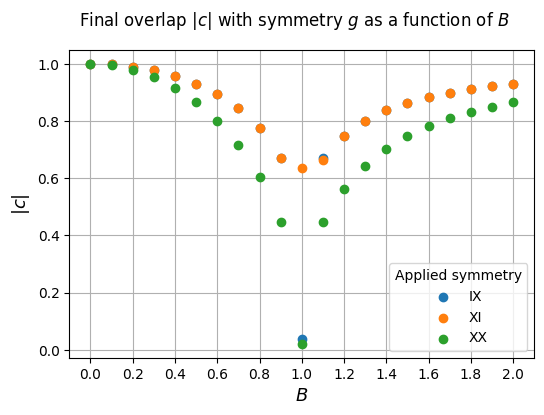

In [61]:
fig, ax = plt.subplots(figsize=(6,4))

for j, (col, label) in enumerate(zip(colors, symmetry_labels[1:])):
    plt.scatter(
        b_params,
        scores[:, j],
        color=col,
        label = label
    )

ax.xaxis.set_major_locator(
    matplotlib.ticker.MultipleLocator(0.2)
)

#ax.set_yscale('log')

ax.grid()
ax.grid(
    which='minor',
    axis='y',
    linestyle='--',
    zorder=-1e10
)
ax.set_axisbelow(True)

ax.set_ylabel(r'$\vert c\vert$', fontsize=13)
ax.set_xlabel('$B$', fontsize=13)

ax.legend(loc='lower right', title='Applied symmetry')

fig.suptitle(r'Final overlap $\vert c \vert$ with symmetry $g$ as a function of $B$')

#fig.savefig(r'plots/ed_cost_function_from_svd_bosonic.png', dpi=200)

In [48]:
proj_rep_phases = list()

for t in b_params:
    psi = psi_dict[t]

    rdm = generate_problem_rdm(
        psi,
        [],
        leftmost_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    left_rdm = (
        rdm
        .trace('b_right', 'k_right')
        .transpose('k_left', 'b_left')
        .data
    )
    right_rdm = (
        rdm
        .trace('b_left', 'k_left')
        .transpose('k_right', 'b_right')
        .data
    )

    unitary_pairs = [results_dict[(t, i)][0] for i in [1,2,3]]
    left_unitaries, right_unitaries = zip(*unitary_pairs)

    left_unitaries = [
        lu.transpose('b_left', 'k_left').data
        for lu in left_unitaries
    ]

    right_unitaries = [
        ru.transpose('b_right', 'k_right').data
        for ru in right_unitaries
    ]
    left_phases = get_proj_rep_phases(left_rdm, left_unitaries)
    right_phases = get_proj_rep_phases(right_rdm, right_unitaries)

    proj_rep_phases.append([left_phases, right_phases])

In [50]:
proj_rep_phases = np.array(proj_rep_phases)

In [51]:
proj_rep_phases.shape

(21, 2, 6)

In [52]:
b_params

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

In [53]:
len(b_params)

21

In [54]:
np.round(
    proj_rep_phases[..., ::2]/proj_rep_phases[..., 1::2],
    2
)

array([[[-1.  +0.j  , -1.  -0.j  , -1.  -0.j  ],
        [-1.  -0.j  , -1.  +0.j  , -1.  +0.j  ]],

       [[-1.  -0.j  , -1.  -0.j  , -1.  +0.j  ],
        [-1.  -0.j  , -1.  -0.j  , -1.  +0.j  ]],

       [[-1.  +0.j  , -1.  +0.j  , -1.  -0.j  ],
        [-1.  +0.j  , -1.  +0.j  , -1.  -0.j  ]],

       [[-1.  +0.j  , -1.  -0.j  , -1.  -0.j  ],
        [-1.  -0.j  , -1.  -0.j  , -1.  +0.j  ]],

       [[-1.  -0.j  , -1.  +0.j  , -1.  +0.j  ],
        [-1.  -0.j  , -1.  -0.j  , -1.  +0.j  ]],

       [[-1.  -0.j  , -1.  +0.j  , -1.  +0.j  ],
        [-1.  -0.j  , -1.  +0.j  , -1.  -0.j  ]],

       [[-1.  -0.j  , -1.  +0.j  , -1.  -0.j  ],
        [-1.  -0.j  , -1.  +0.j  , -1.  +0.j  ]],

       [[-1.  -0.j  , -1.  +0.j  , -1.  +0.j  ],
        [-1.  -0.j  , -1.  -0.j  , -1.  +0.j  ]],

       [[-1.  +0.j  , -1.  +0.j  , -1.  +0.j  ],
        [-1.  -0.j  , -1.  -0.j  , -1.  -0.j  ]],

       [[-1.  +0.j  , -1.  -0.j  , -1.  +0.j  ],
        [-1.  +0.j  , -1.  -0.j  , -1.  -0.j  ]],



In [65]:
gauge_invariant_proj_rep_phase = proj_rep_phases[..., ::2]/proj_rep_phases[..., 1::2]

In [66]:
gauge_invariant_proj_rep_angle = np.imag(np.log(gauge_invariant_proj_rep_phase))
gauge_invariant_proj_rep_angle[gauge_invariant_proj_rep_angle<=-np.pi/2] += 2*np.pi

In [67]:
mean_gauge_invariant_proj_rep_angle = np.mean(gauge_invariant_proj_rep_angle, axis=(1,2))
max_gauge_invariant_proj_rep_angle = np.max(gauge_invariant_proj_rep_angle, axis=(1,2))
min_gauge_invariant_proj_rep_angle = np.min(gauge_invariant_proj_rep_angle, axis=(1,2))

min_max_gauge_invariant_proj_rep_angle = np.stack(
    [
        min_gauge_invariant_proj_rep_angle,
        max_gauge_invariant_proj_rep_angle
    ],
    axis=0
)

error_gauge_invariant_proj_rep_angle = (
    min_max_gauge_invariant_proj_rep_angle
    - mean_gauge_invariant_proj_rep_angle[np.newaxis, :]
)
error_gauge_invariant_proj_rep_angle = np.abs(error_gauge_invariant_proj_rep_angle)

In [68]:
np.max(error_gauge_invariant_proj_rep_angle)

1.8634249575207529

"\nfig.savefig(\n    r'plots/unitary_circuit_bosonic_ed_results.png',\n    bbox_inches='tight',\n    dpi=200\n)\n"

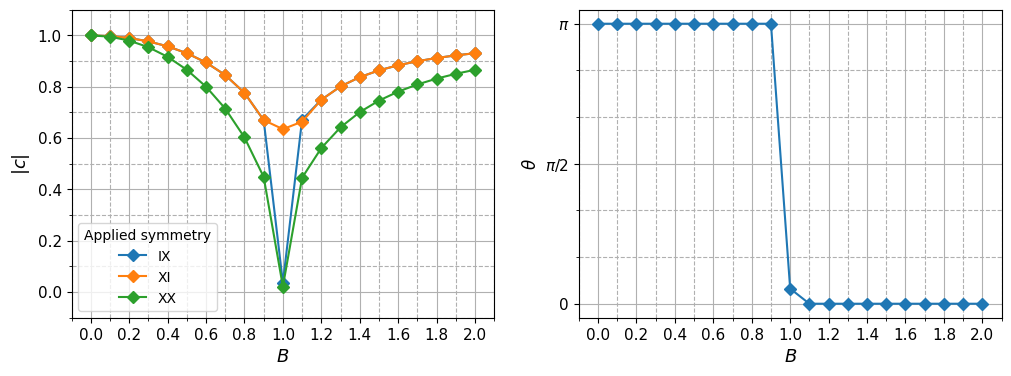

In [69]:
fig, [ax1, ax2] = plt.subplots(figsize=(12, 4), ncols=2)

for i in range(1, 4):
    ax1.plot(
        b_params,
        scores[:, i-1],
        label=symmetry_labels[i],
        marker='D'
    )

ax1.set_ylabel(r'$\vert c \vert$', fontsize=13)
ax1.legend(title='Applied symmetry')
ax1.set_ylim(-0.1, 1.1)
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(MultipleLocator(0.1))


ax2.plot(
    b_params,
    mean_gauge_invariant_proj_rep_angle,
    color='tab:blue',
    marker='D'
)

ax2.set_yticks(
    np.linspace(0, np.pi, 3),
    labels=['$0$', '$\pi/2$', '$\pi$']
)

ax2.set_yticks(
    [np.pi/6, np.pi/3, 2*np.pi/3, 5*np.pi/6],
    minor=True
)

ax2.set_ylabel(r'$\theta$', fontsize=12)

for ax in [ax1, ax2]:
    ax.grid()
    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))

    ax.set_xlabel('$B$', fontsize=13)

    ax.tick_params(
        axis='both',
        which='major',
        labelsize=11
    )

    ax.grid(
        which='minor',
        linestyle='--',
    )

"""
fig.savefig(
    r'plots/unitary_circuit_bosonic_ed_results.png',
    bbox_inches='tight',
    dpi=200
)
"""

In [71]:
with open(r'../make_plots/data/bosonic_results/mps_svd_b_params.pkl', 'wb') as f:
    pickle.dump(b_params, f)

with open(r'../make_plots/data/bosonic_results/mps_svd_mean_gauge_invariant_proj_rep_angle.pkl', 'wb') as f:
    pickle.dump(mean_gauge_invariant_proj_rep_angle, f)

with open(r'../make_plots/data/bosonic_results/mps_svd_error_gauge_invariant_proj_rep_angle.pkl', 'wb') as f:
    pickle.dump(error_gauge_invariant_proj_rep_angle, f)

with open(r'../make_plots/data/bosonic_results/mps_svd_overlaps.pkl', 'wb') as f:
    pickle.dump(scores, f)

# Conclusion
Looks good!